In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)

In [3]:
import arviz as az
import pandas as pd
import equinox as eqx
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random, nn, vmap
from functools import partial
import optax

from numpyro.infer import log_likelihood, Predictive

from models import exact_blr, log_ratio, BayesRegression, SVIRegression, BMRRegression

data set N D
Yacht 308 6
Boston 506 13
Energy 768 8
Concrete 1030 8
Wine 1599 11
Kin8nm 8192 8
Power Plant 9568 4
Naval 11,934 16
Protein 45,730 9
Year 515,345 90

In [7]:
# Gas Sensor Array Drift Dataset Data Set
path =  'https://archive.ics.uci.edu/ml/machine-learning-databases/00224/Dataset.zip'
df7 = pd.read_csv(path, compression='zip', header=None)

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['Dataset/', 'Dataset/batch1.dat', 'Dataset/batch10.dat', 'Dataset/batch2.dat', 'Dataset/batch3.dat', 'Dataset/batch4.dat', 'Dataset/batch5.dat', 'Dataset/batch6.dat', 'Dataset/batch7.dat', 'Dataset/batch8.dat', 'Dataset/batch9.dat']

In [12]:
# Myocardial infarction complications Data Set
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00579/MI.data'
df7 = pd.read_csv(path, header=None, index_col=0)

inputs = df7.loc[:, :111]
outcomes = df7.loc[:, 112:] # binary (112-123), categorical (123)

In [4]:
# load data

# likelihood normal
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
df1 = pd.read_csv(path, index_col=False, header=None, sep='\t')
df1.columns = ['Frequency', 'Angle', 'Chord', 'Velocity', 'Thickness', 'Pressure']

path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data'
df2 = pd.read_csv(path, index_col=False, header=None, sep=None)
df2.columns = ['Position', 'Coefficient', 'Length-displacement', 'Beam-draught', 'Length-beam', 'Froude', 'Resistance']
df2 = df2.fillna(value=0)
df2 -= df2.mean()
df2.loc[:, :'Froude'] /= df2.loc[:, :'Froude'].std()

path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls'
df4 = pd.read_excel(path)
df4 -= df4.mean()
df4.loc[:, :'Age (day)'] /= df4.loc[:, :'Age (day)'].std()

path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00437/Residential-Building-Data-Set.xlsx'
df5 = pd.read_excel(path)

# likelihood bernoulli 

path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
df3 = pd.read_csv(path, index_col=False, header=None, sep=None)

path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data'
df6 = pd.read_csv(path, header=None)

X_bern = jnp.array(df6.loc[:, 3:33])
X_bern -= X_bern.mean(0)
X_bern /= X_bern.std(0)

y_bern = jnp.array(df6[1] == 'R')

# likleihood categorical

path =  'https://archive.ics.uci.edu/ml/machine-learning-databases/00224/Dataset.zip'
df7 = pd.read_csv(path, compression='zip', header=0, sep=',', quotechar='"')


X_norm = jnp.array(df2.loc[:, :'Froude'])
X_norm = jnp.concatenate([X_norm, jnp.ones((len(X_norm), 1))], -1)
N, D = X_norm.shape
y_norm = jnp.array(df2.Resistance)

rng_key = random.PRNGKey(3742)

/tmp/ipykernel_689748/960717617.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df2 = pd.read_csv(path, index_col=False, header=None, sep=None)
/tmp/ipykernel_689748/960717617.py:9: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df2 = pd.read_csv(path, index_col=False, header=None, sep=None)
/tmp/ipykernel_689748/960717617.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df3 = pd.read_csv(path, index_col=False, header=None, sep=None)
/tmp/ipykernel_689748/960717617.py:26: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df3 = pd.read_csv(path, in

## Normal likelihood - linear regression

In [5]:
mu_n, P_n, a_n, b_n = exact_blr(X_norm, y_norm)
L_n = jnp.linalg.cholesky(jnp.linalg.inv(P_n))

params = {
    'a': a_n,
    'b': b_n,
    'mu': mu_n,
    'L': L_n,
}

rng_key, _rng_key = random.split(rng_key)
sigma_square = dist.InverseGamma(a_n, b_n).sample(_rng_key, sample_shape=(1000,))

rng_key, _rng_key = random.split(rng_key)
eps = jnp.expand_dims(jnp.sqrt(sigma_square), -1) * random.normal(_rng_key, shape=(1000, D))
betas = mu_n + (L_n @ eps.T).T

samples = {
    'beta': betas,
    'sigma': jnp.sqrt(sigma_square)
}

lr = partial(log_ratio, X_norm, y_norm, params)
print('F', vmap(lr)(samples).mean())

F 1212.5603


129.91803 10.469093


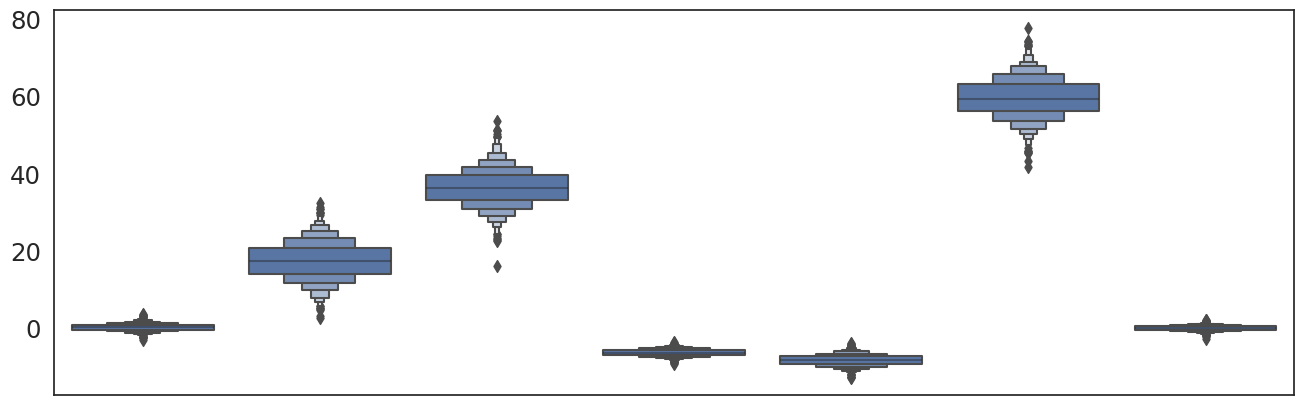

In [6]:
print( b_n/(a_n - 1), b_n/ jnp.sqrt((a_n-1)**2 * (a_n - 2)) )

plt.figure(figsize=(16, 5))
sns.boxenplot(betas, color='b');
plt.xticks(ticks=[]);

In [5]:
posterior = {
    'nobmr': {},
    'bmr': {},
    'svi': {},
    'mcmc': {}
}

nonlin_posterior = posterior.copy()

## No-U-turn sampler

sample: 100%|██████████| 750/750 [02:20<00:00,  5.34it/s]


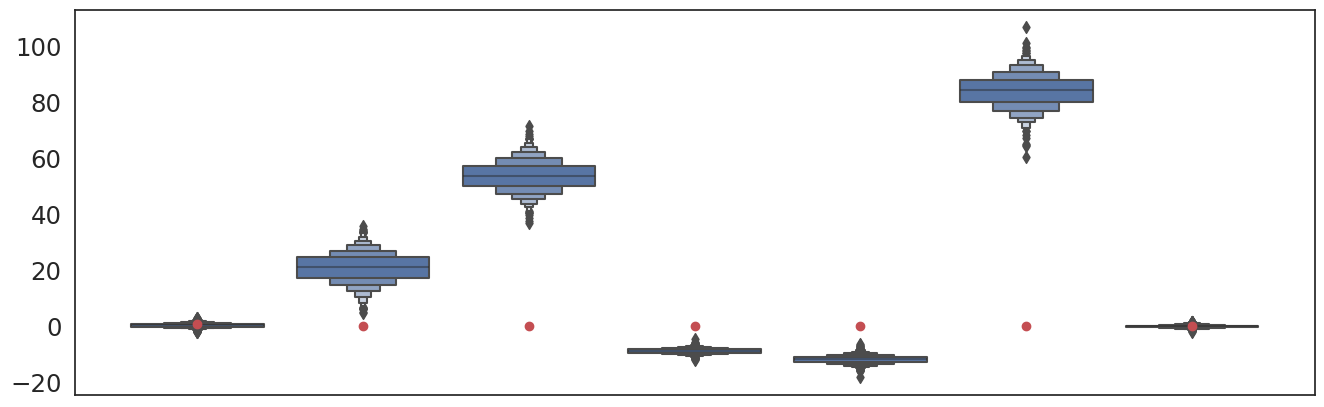

In [8]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D, 1, use_bias=False, key=_rng_key)])

bayes_reg = BayesRegression(_rng_key, X_norm, linnet)
smpl_norm = bayes_reg.fit(y_norm, num_samples=250, warmup_steps=500, num_chains=4, progress_bar=True)
posterior['mcmc']['norm'] = smpl_norm['beta']

plt.figure(figsize=(16, 5))
sns.boxenplot(smpl_norm['beta'], color='b');
plt.xticks(ticks=[]);

## Stochastic variational inference

100%|██████████| 50000/50000 [00:41<00:00, 1205.46it/s, init loss: 36177.5625, avg. loss [47501-50000]: 1208.5431]


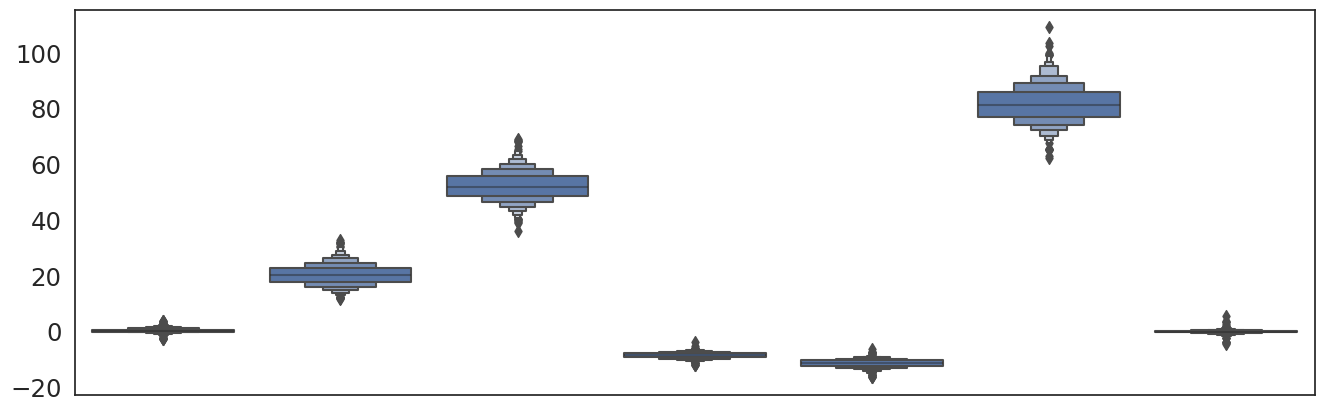

In [9]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D, 1, use_bias=False, key=_rng_key)])

svi_reg = SVIRegression(_rng_key, X_norm, linnet, regtype='linear')
svi_smpl_norm = svi_reg.fit(y_norm, num_steps=50_000, autoguide='multivariate', progress_bar=True)
posterior['svi']['norm'] = svi_smpl_norm['beta']

plt.figure(figsize=(16, 5))
sns.boxenplot(svi_smpl_norm['beta'], color='b');
plt.xticks(ticks=[]);

## Bayesian model reduction

100%|██████████| 20000/20000 [00:21<00:00, 920.11it/s, init loss: 870.2707, avg. loss [19001-20000]: -207.1180] 


<dF> + F:  1035.6282


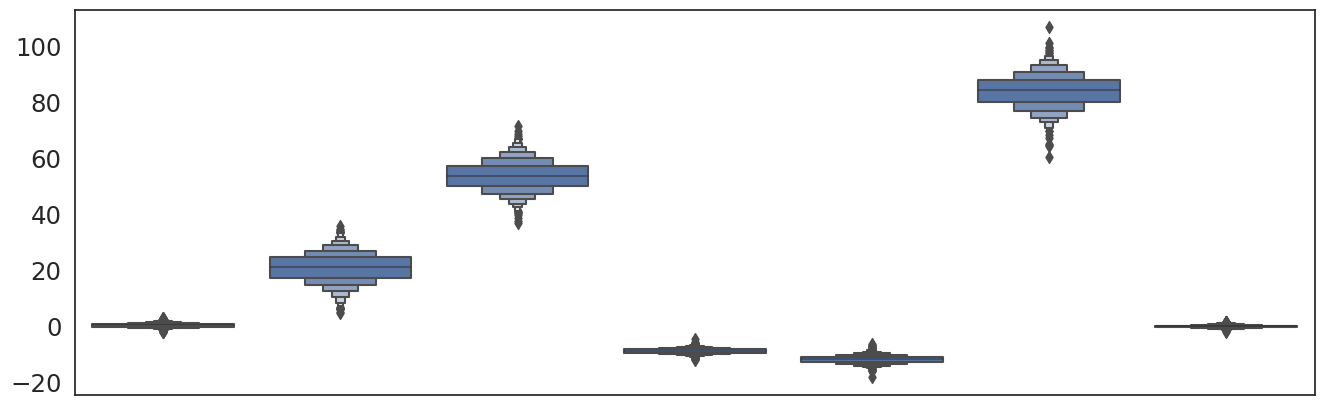

In [10]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D, 1, use_bias=False, key=_rng_key)])

rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_norm, linnet, posterior='multivariate')
nobmr_smpl_norm = bmr_reg.fit(y_norm, num_steps=30_000, progress_bar=True)
posterior['nobmr']['norm'] = nobmr_smpl_norm['beta']

results, bmr_smpl_norm = bmr_reg.bmr('multivariate', num_steps=20_000, progress_bar=True)
posterior['bmr']['norm'] = bmr_smpl_norm['beta']
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

plt.figure(figsize=(16, 5))
sns.boxenplot(smpl_norm['beta'], color='b');
plt.xticks(ticks=[]);

## Nonlinear regression
$$ f(X) = {W}_2 \cdot ReLU(\pmb{W}_1 \cdot X)$$
$$ y \sim p\left(y| f(\pmb{X}), \pmb{\Theta}\right)$$

$$ p(W_1, W_2| \mathcal{D} ) \approx \prod_{ij} q(w^1_{ij}) \prod_{km} q(w^2_{ij})$$ 

In [11]:
hidden_dim = 50
rng_key, _rng_key = random.split(rng_key)
nnet1 = eqx.nn.MLP(D, 1, hidden_dim, 1, use_bias=False, key=_rng_key)

## No-U-turn sampler

In [30]:
rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_norm, nnet1)
smpl_norm = bayes_reg.fit(
    y_norm, 
    num_samples=1000, 
    warmup_steps=1000, 
    num_chains=1,
    progress_bar=True
)

nonlin_posterior['mcmc']['norm'] = smpl_norm

sample: 100%|██████████| 2000/2000 [16:17<00:00,  2.05it/s, 1023 steps of size 1.90e-04. acc. prob=0.85]


In [43]:
data = az.from_numpyro(bayes_reg.mcmc)
az.loo(data)

/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 308 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -411.80    18.33
p_loo       52.21        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      291   94.5%
 (0.5, 0.7]   (ok)          9    2.9%
   (0.7, 1]   (bad)         6    1.9%
   (1, Inf)   (very bad)    2    0.6%

## Stochastic variational inference

In [31]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_norm, nnet1)
svi_smpl_norm = svi_reg.fit(
    y_norm, 
    num_steps=100_000, 
    autoguide='mean-field', 
    progress_bar=True
)
nonlin_posterior['svi']['norm'] = svi_smpl_norm

100%|██████████| 100000/100000 [04:33<00:00, 365.56it/s, init loss: 9886.5605, avg. loss [95001-100000]: 1135.0905]


## Bayesian model reduction

In [35]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_norm, nnet1, posterior='normal')

nobmr_smpl_norm = bmr_reg.fit(
    y_norm, 
    num_steps=70_000, 
    progress_bar=True
)

nonlin_posterior['nobmr']['norm'] = nobmr_smpl_norm

100%|██████████| 70000/70000 [01:25<00:00, 815.90it/s, init loss: 54576.9023, avg. loss [66501-70000]: 1252.2729]


In [36]:
results, bmr_smpl_norm = bmr_reg.bmr(
    'mean-field',
    num_steps=30_000, 
    progress_bar=True
)

nonlin_posterior['bmr']['norm'] = bmr_smpl_norm
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 30000/30000 [00:56<00:00, 531.90it/s, init loss: 13373.2520, avg. loss [28501-30000]: -1181.7599]


<dF> + F:  69.993286


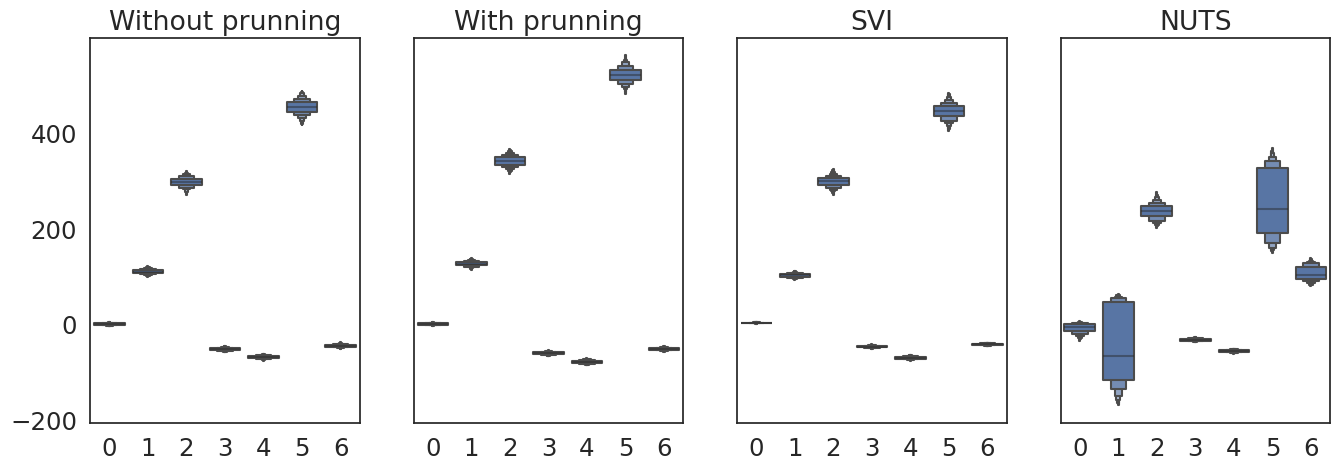

In [39]:
    fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey='row')

    sns.boxenplot(nonlin_posterior['nobmr']['norm']['beta'], color='b', ax=axes[0], showfliers=False, outlier_prop=1e-3);
    axes[0].set_title('Without prunning')

    sns.boxenplot(nonlin_posterior['bmr']['norm']['beta'], color='b', ax=axes[1], showfliers=False, outlier_prop=1e-3);
    axes[1].set_title('With prunning')

    sns.boxenplot(nonlin_posterior['svi']['norm']['beta'], color='b', ax=axes[2], showfliers=False, outlier_prop=1e-3);
    axes[2].set_title('SVI')

    sns.boxenplot(nonlin_posterior['mcmc']['norm']['beta'], color='b', ax=axes[3], showfliers=False, outlier_prop=1e-3);
    axes[3].set_title('NUTS');

# Bernoulli likelihood - logistic regression

In [6]:
N, D = X_bern.shape
assert y_bern.shape == (N,)

In [8]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D + 1, 1, use_bias=False, key=_rng_key)])

bayes_reg = BayesRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), linnet, regtype='logistic')
smpl_bern = bayes_reg.fit(y_bern, num_samples=250, warmup_steps=500, num_chains=4, progress_bar=True)
posterior['mcmc']['bern'] = smpl_bern

idata = az.from_numpyro(bayes_reg.mcmc)
az.loo(idata)

sample: 100%|██████████| 750/750 [00:14<00:00, 52.19it/s] 


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -107.36     7.05
p_loo        6.39        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      196   99.0%
 (0.5, 0.7]   (ok)          2    1.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

100%|██████████| 50000/50000 [00:45<00:00, 1103.45it/s, init loss: 440.9464, avg. loss [47501-50000]: 125.7669]


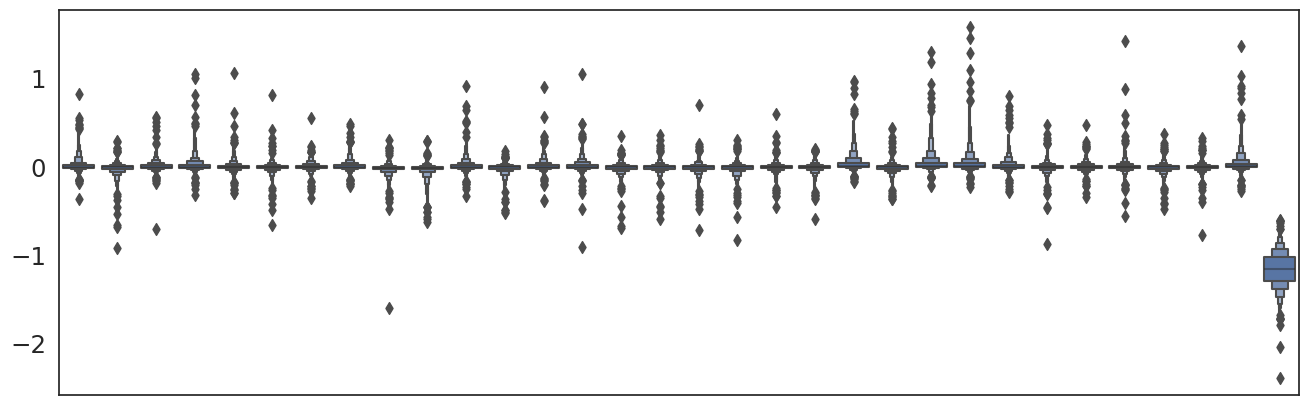

In [8]:
svi_reg = SVIRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), linnet, regtype='logistic')
svi_smpl_bern = svi_reg.fit(y_bern, num_steps=50_000, autoguide='multivariate', progress_bar=True)
posterior['svi']['bern'] = svi_smpl_bern

In [9]:
dims = {'obs': ['sample']}

post_smpl = {}
for key in posterior['svi']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(posterior['svi']['bern'][key], 0)

log_lik = log_likelihood(
    svi_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, dims=dims)
az.loo(idata)

/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -111.25     6.87
p_loo        6.70        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      152   76.8%
 (0.5, 0.7]   (ok)         34   17.2%
   (0.7, 1]   (bad)        12    6.1%
   (1, Inf)   (very bad)    0    0.0%

100%|██████████| 20000/20000 [00:26<00:00, 743.13it/s, init loss: 212.8356, avg. loss [19001-20000]: 2.9689]


<dF> + F:  124.10278


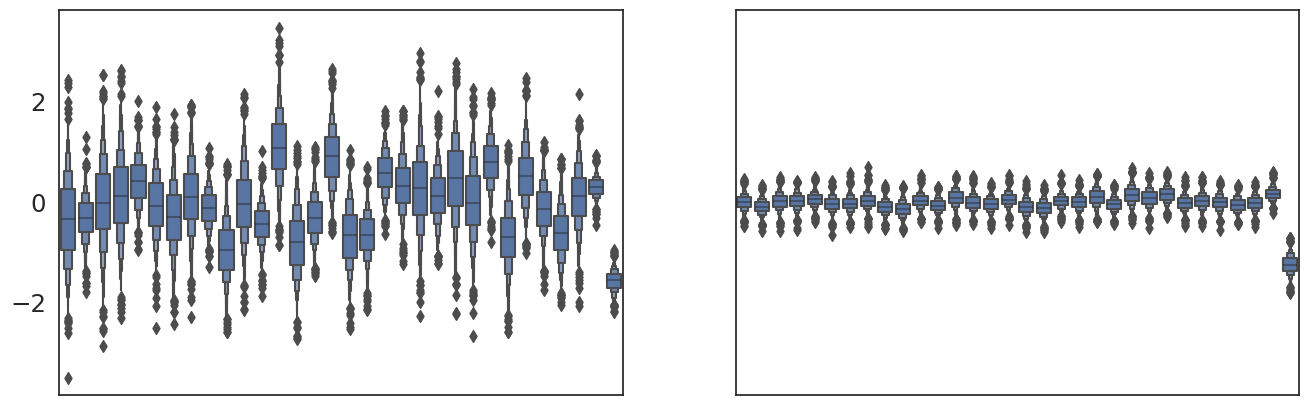

In [9]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), linnet, posterior='multivariate', regtype='logistic')
nobmr_smpl_bern = bmr_reg.fit(y_bern, num_steps=30_000, progress_bar=True)
posterior['nobmr']['bern'] = nobmr_smpl_bern

results, bmr_smpl_bern = bmr_reg.bmr('multivariate', num_steps=20_000, progress_bar=True)
posterior['bmr']['bern'] = bmr_smpl_bern
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True, sharey=True)
sns.boxenplot(nobmr_smpl_bern['beta'], color='b', ax=axes[0]);
sns.boxenplot(bmr_smpl_bern['beta'], color='b', ax=axes[1]);
plt.xticks(ticks=[]);

In [11]:
post_smpl = {}
for key in posterior['nobmr']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(posterior['nobmr']['bern'][key], 0)

log_lik = log_likelihood(
    bmr_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, dims=dims)
az.loo(idata)

/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -109.06     8.39
p_loo       21.29        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      188   94.9%
 (0.5, 0.7]   (ok)          8    4.0%
   (0.7, 1]   (bad)         1    0.5%
   (1, Inf)   (very bad)    1    0.5%

In [12]:
post_smpl = {}
for key in posterior['bmr']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(posterior['bmr']['bern'][key], 0)

log_lik = log_likelihood(
    bmr_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, dims=dims)
az.loo(idata)

Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -106.29     7.21
p_loo        7.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      197   99.5%
 (0.5, 0.7]   (ok)          1    0.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [7]:
hidden_dim = 50
rng_key, _rng_key = random.split(rng_key)
nnet1 = eqx.nn.MLP(D + 1, 1, hidden_dim, 1, use_bias=False, key=_rng_key)

In [14]:
bayes_reg = BayesRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), nnet1, regtype='logistic')
smpl_bern = bayes_reg.fit(y_bern, num_samples=250, warmup_steps=500, num_chains=4, progress_bar=True)
nonlin_posterior['mcmc']['bern'] = smpl_bern

sample: 100%|██████████| 750/750 [00:37<00:00, 19.75it/s]


In [15]:
dims = {"obs": ["sample"]}
idata_kwargs = {
    "dims": dims
}

idata = az.from_numpyro(bayes_reg.mcmc, **idata_kwargs)
loo_orig = az.loo(idata, pointwise=True)
loo_orig

/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -106.87     7.23
p_loo       15.01        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      188   94.9%
 (0.5, 0.7]   (ok)          9    4.5%
   (0.7, 1]   (bad)         1    0.5%
   (1, Inf)   (very bad)    0    0.0%

In [16]:
svi_reg = SVIRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), nnet1, regtype='logistic')
svi_smpl_bern = svi_reg.fit(y_bern, num_steps=50_000, autoguide='mean-field', progress_bar=True)
nonlin_posterior['svi']['bern'] = svi_smpl_bern

100%|██████████| 50000/50000 [02:11<00:00, 380.44it/s, init loss: 15278.1123, avg. loss [47501-50000]: 654.7667]


In [17]:
post_smpl = {}
for key in nonlin_posterior['svi']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(nonlin_posterior['svi']['bern'][key], 0)

log_lik = log_likelihood(
    svi_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, **idata_kwargs)
az.loo(idata)

/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -157.76     9.58
p_loo       43.01        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       24   12.1%
 (0.5, 0.7]   (ok)         58   29.3%
   (0.7, 1]   (bad)        74   37.4%
   (1, Inf)   (very bad)   42   21.2%

In [8]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), nnet1, posterior='normal', regtype='logistic')
nobmr_smpl_bern = bmr_reg.fit(y_bern, num_steps=80_000, progress_bar=True)
nonlin_posterior['nobmr']['bern'] = nobmr_smpl_bern

results, bmr_smpl_bern = bmr_reg.bmr('mean-field', num_steps=20_000, progress_bar=True)
nonlin_posterior['bmr']['bern'] = bmr_smpl_bern
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 20000/20000 [00:38<00:00, 523.67it/s, init loss: 11014.3564, avg. loss [19001-20000]: 364.8427]


<dF> + F:  622.1381


In [12]:
dims = {"obs": ["sample"]}
idata_kwargs = {
    "dims": dims
}

post_smpl = {}
for key in nonlin_posterior['nobmr']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(nonlin_posterior['nobmr']['bern'][key], 0)

log_lik = log_likelihood(
    bmr_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, dims=dims)
az.loo(idata)

/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -201.95    16.29
p_loo       96.96        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       82   41.4%
 (0.5, 0.7]   (ok)         65   32.8%
   (0.7, 1]   (bad)        40   20.2%
   (1, Inf)   (very bad)   11    5.6%

In [13]:
post_smpl = {}
for key in nonlin_posterior['bmr']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(nonlin_posterior['bmr']['bern'][key], 0)

log_lik = log_likelihood(
    bmr_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, dims=dims)
az.loo(idata)

Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -137.18     0.01
p_loo        0.01        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      198  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [21]:
hidden_dim = 50
rng_key, _rng_key = random.split(rng_key)
nnet1 = eqx.nn.MLP(D + 1, 1, hidden_dim, 3, use_bias=False, key=_rng_key)

In [22]:
bayes_reg = BayesRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), nnet1, regtype='logistic')
smpl_bern = bayes_reg.fit(y_bern, num_samples=250, warmup_steps=500, num_chains=4, progress_bar=True)
nonlin_posterior['mcmc']['bern'] = smpl_bern

idata = az.from_numpyro(bayes_reg.mcmc)
az.loo(idata)

sample: 100%|██████████| 750/750 [03:19<00:00,  3.76it/s]
/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -105.71     7.14
p_loo       17.12        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      170   85.9%
 (0.5, 0.7]   (ok)         27   13.6%
   (0.7, 1]   (bad)         1    0.5%
   (1, Inf)   (very bad)    0    0.0%

In [23]:
svi_reg = SVIRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), nnet1, regtype='logistic')
svi_smpl_bern = svi_reg.fit(y_bern, num_steps=50_000, autoguide='mean-field', progress_bar=True)
nonlin_posterior['svi']['bern'] = svi_smpl_bern

post_smpl = {}
for key in nonlin_posterior['svi']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(nonlin_posterior['svi']['bern'][key], 0)

log_lik = log_likelihood(
    svi_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, **idata_kwargs)
az.loo(idata)

100%|██████████| 50000/50000 [04:25<00:00, 187.98it/s, init loss: 61243.7148, avg. loss [47501-50000]: 2230.4055]
/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -142.34     1.87
p_loo        9.52        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        6    3.0%
 (0.5, 0.7]   (ok)         40   20.2%
   (0.7, 1]   (bad)       101   51.0%
   (1, Inf)   (very bad)   51   25.8%

In [35]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, jnp.concatenate([X_bern, jnp.ones((N, 1))], -1), nnet1, posterior='multivariate', regtype='logistic')
nobmr_smpl_bern = bmr_reg.fit(y_bern, num_steps=50_000, progress_bar=True)
nonlin_posterior['nobmr']['bern'] = nobmr_smpl_bern

results, bmr_smpl_bern = bmr_reg.bmr('mean-field', num_steps=20_000, progress_bar=True)
nonlin_posterior['bmr']['bern'] = bmr_smpl_bern
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 20000/20000 [02:36<00:00, 127.42it/s, init loss: 44465.2070, avg. loss [19001-20000]: 1767.1989]


<dF> + F:  2174.4797


In [36]:
post_smpl = {}
for key in nonlin_posterior['nobmr']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(nonlin_posterior['nobmr']['bern'][key], 0)

log_lik = log_likelihood(
    bmr_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, dims=dims)
az.loo(idata)

/home/dimitrije/micromamba/envs/numpc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -253.19    22.45
p_loo      146.77        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       59   29.8%
 (0.5, 0.7]   (ok)         48   24.2%
   (0.7, 1]   (bad)        63   31.8%
   (1, Inf)   (very bad)   28   14.1%

In [37]:
post_smpl = {}
for key in nonlin_posterior['bmr']['bern']:
    if key != 'obs':
        post_smpl[key] = jnp.expand_dims(nonlin_posterior['bmr']['bern'][key], 0)

log_lik = log_likelihood(
    bmr_reg.model, post_smpl, parallel=True, batch_ndims=2, obs=y_bern
)

idata = az.convert_to_inference_data(post_smpl)
idata.add_groups(log_likelihood=log_lik, dims=dims)
az.loo(idata)

Computed from 1000 posterior samples and 198 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -136.27     0.11
p_loo        0.01        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      198  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<AxesSubplot: >

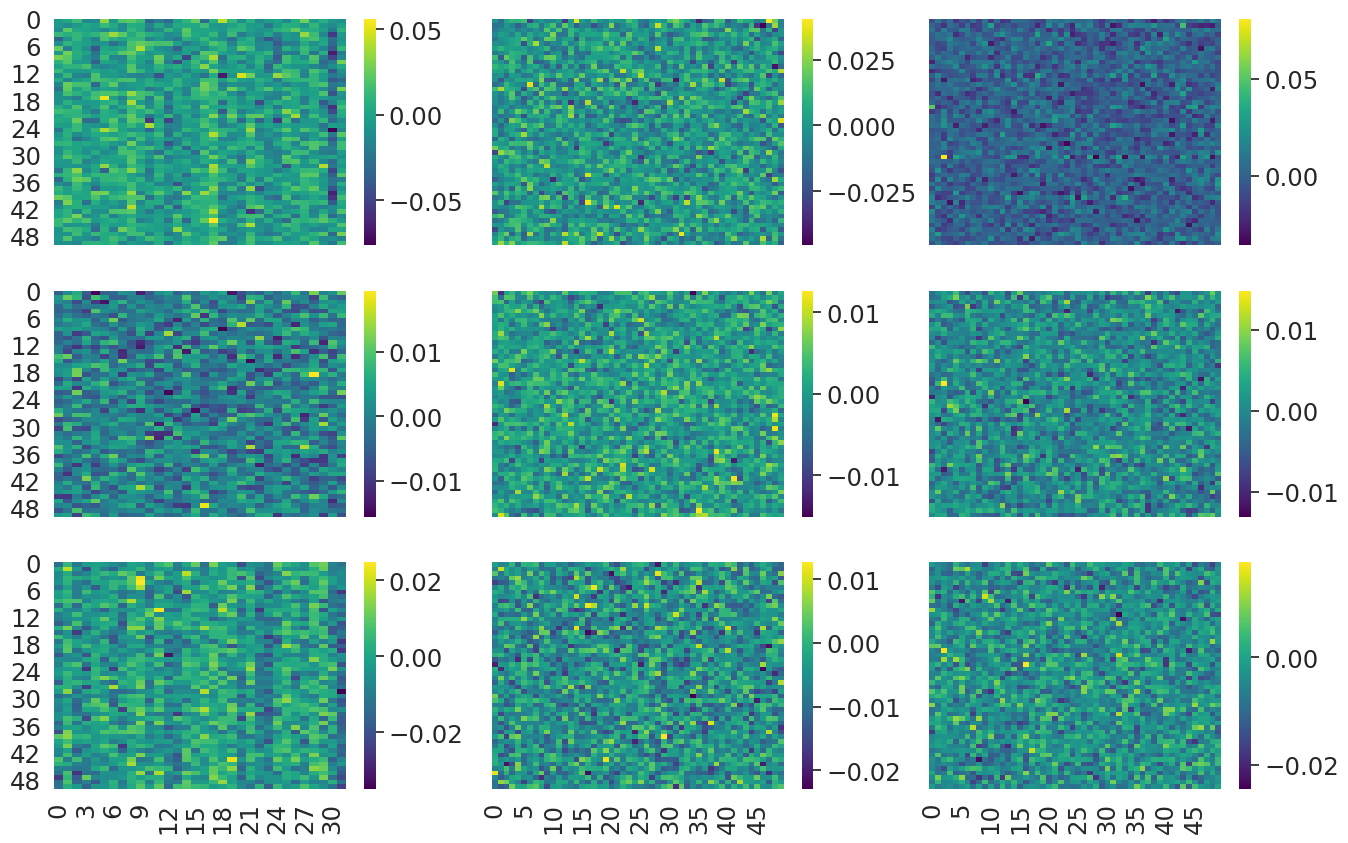

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10), sharex='col', sharey='row')

sns.heatmap(nonlin_posterior['mcmc']['bern']['layer0.weight'].mean(0), ax=axes[0, 0], cmap='viridis')
sns.heatmap(nonlin_posterior['mcmc']['bern']['layer1.weight'].mean(0), ax=axes[0, 1], cmap='viridis')
sns.heatmap(nonlin_posterior['mcmc']['bern']['layer2.weight'].mean(0), ax=axes[0, 2], cmap='viridis')

sns.heatmap(nonlin_posterior['svi']['bern']['layer0.weight'].mean(0), ax=axes[1, 0], cmap='viridis')
sns.heatmap(nonlin_posterior['svi']['bern']['layer1.weight'].mean(0), ax=axes[1, 1], cmap='viridis')
sns.heatmap(nonlin_posterior['svi']['bern']['layer2.weight'].mean(0), ax=axes[1, 2], cmap='viridis')

sns.heatmap(nonlin_posterior['bmr']['bern']['layer0.weight'].mean(0), ax=axes[-1, 0], cmap='viridis')
sns.heatmap(nonlin_posterior['bmr']['bern']['layer1.weight'].mean(0), ax=axes[-1, 1], cmap='viridis')
sns.heatmap(nonlin_posterior['bmr']['bern']['layer2.weight'].mean(0), ax=axes[-1, 2], cmap='viridis')